In [1]:
from IPython.display import Image

- https://www.anthropic.com/engineering/building-effective-agents
    - https://mirror-feeling-d80.notion.site/Workflow-And-Agents-17e808527b1780d792a0d934ce62bee6
        - https://langchain-ai.github.io/langgraph/tutorials/workflows/
        - https://www.youtube.com/watch?v=aHCDrAbH_go
- AlphaEvolve: coding agent
    - llm 作为核心算子实现遗传算法；
    - 适用于可以自动评估的环境；& 大量脚手架类似的工作；
- https://github.com/google-gemini/gemini-fullstack-langgraph-quickstart/tree/main
    - 基于 langgraph 编排工作流实现 deepresearch
        - 不同的节点用不同的 gemini models
        - pro：deep，flash：width
- sota llms (gemini 2.5 pro, openai o3) + 精心设计的 workflow（脚手架，scaffolding）能解决非常多非常复杂的问题；
    - 基础模型实在是越来越powerful了

In [2]:
Image(url='https://mirror-feeling-d80.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Fc2810b1e-a85a-492f-bc51-5aa2decfa5ac%2Ffb35bebb-2ad8-48d5-ad83-b93dd3f6e6b8%2Fimage.png?table=block&id=18080852-7b17-8024-82ab-d5bd13b9ff42&spaceId=c2810b1e-a85a-492f-bc51-5aa2decfa5ac&width=1420&userId=&cache=v2', 
      width=800)

- workflows
    - Create a scaffolding of predefined code paths around llm calls
    - LLMs directs control flow through predefined code paths
- Agen: remove this scaffolding (LLM directs its own actions, responds to feedback)

In [3]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
assert load_dotenv()
llm = ChatOpenAI(model='gpt-4o-mini')

### Augmented LLM

- Augment the LLM with schema for structured output
- Augment the LLM with tools

In [6]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/augmented_llm.png', width=500)

In [7]:
# Schema for structured output => output schema
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

In [8]:
# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

In [9]:
output

SearchQuery(search_query='Calcium CT score high cholesterol relationship', justification='This query targets the relationship between calcium CT scores and cholesterol levels, which may help in understanding cardiovascular risk assessment.')

In [10]:
structured_llm.invoke("今年高考新闻")

SearchQuery(search_query='2023年高考 新闻 相关报道', justification='搜索2023年高考的相关新闻，以获取该年度高考的最新动态、政策变化及新闻事件等信息，符合用户对今年高考的关注。')

In [11]:
# Define a tool
def multiply(a: float, b: float) -> float:
    return a * b
def sigmoid(a: float) -> float:
    return 1./(1+np.exp(-a))

In [12]:
# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply, sigmoid])

In [94]:
# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is derivative of sigmoid(5)")

In [95]:
msg.tool_calls

[{'name': 'sigmoid',
  'args': {'a': 5},
  'id': 'call_PBKMYMxZjU0x8IP9TxMHuE8Y',
  'type': 'tool_call'}]

In [96]:
msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PBKMYMxZjU0x8IP9TxMHuE8Y', 'function': {'arguments': '{"a":5}', 'name': 'sigmoid'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 194, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BiJpUWnwANEG7bDWV9FR6mXp5vHj1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac1635ef-b4cd-4526-af25-f1ba23e22ed7-0', tool_calls=[{'name': 'sigmoid', 'args': {'a': 5}, 'id': 'call_PBKMYMxZjU0x8IP9TxMHuE8Y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 14, 'total_tokens': 208, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [68]:
Image(url='https://python.langchain.com/assets/images/with_structured_output-4fd0fdc94f644554d52c6a8dee96ea21.png', width=500)

### Prompt chaining

In [16]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/prompt_chain.png', width=500)

In [17]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [18]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [19]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""
    # wordplay: 俏皮话/双关语
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


In [20]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()


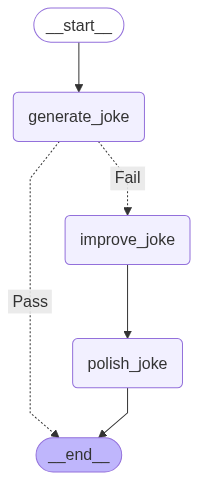

In [21]:
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [22]:
state = chain.invoke({"topic": "cats"})

In [23]:
state

{'topic': 'cats',
 'joke': 'Why did the cat sit on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}

In [24]:
for step in chain.stream({"topic": "dogs"}):
    print(step)

{'generate_joke': {'joke': "Why did the dog sit in the shade? \n\nBecause he didn't want to become a hot dog!"}}


### Parallelization

- LLMs can sometimes work **simultaneously** on a task and have their outputs **aggregated** programmatically. This workflow, parallelization, manifests in two key variations:
    - Sectioning: Breaking a task into independent subtasks run in parallel.
    - Aggregator(Voting): Running the same task multiple times to get diverse outputs.

In [25]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png', width=500)

In [26]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


In [27]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()


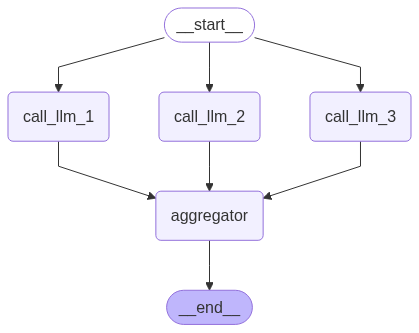

In [28]:
# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

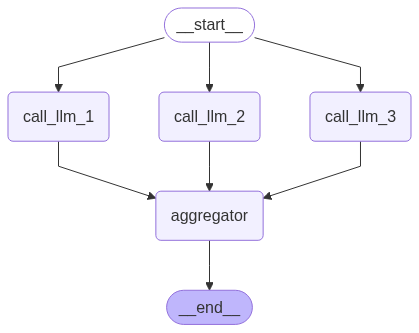

In [29]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})

In [31]:
state.keys()

dict_keys(['topic', 'joke', 'story', 'poem', 'combined_output'])

In [34]:
# print(state['combined_output'])

### Routing

In [35]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/routing.png', width=500)

- Routing classifies an input and directs it to a specialized followup task. This workflow allows for **separation** of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.
- When to use this workflow: Routing works well for **complex tasks** where there are **distinct categories** that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.
    - distinct models (fast non-reasoning model, powerful reasoning model)

In [36]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

In [37]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [38]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [39]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


In [40]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

In [41]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

In [42]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

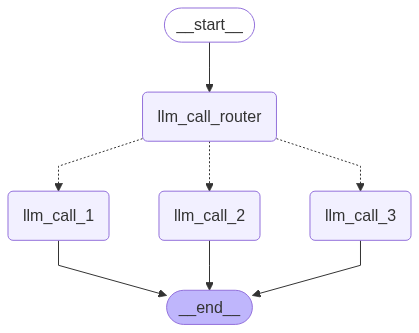

In [43]:
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [44]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})

In [45]:
for step in router_workflow.stream({"input": "Write me a joke about cats"}):
    print(step)

{'llm_call_router': {'decision': 'joke'}}
{'llm_call_2': {'output': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}}


In [46]:
for step in router_workflow.stream({"input": "Write me a poem about cats"}):
    print(step)

{'llm_call_router': {'decision': 'poem'}}
{'llm_call_3': {'output': 'In sunlit corners, shadows play,  \nWhere whispers of the feline sway,  \nWith graceful poise and silent tread,  \nThe world’s a kingdom, theirs to thread.  \n\nA tapestry of fur like night,  \nWith emerald eyes that pierce the light,  \nThey leap as if on dreams they dance,  \nIn elegant arcs, a fleeting glance.  \n\nA soft purr hums, a gentle song,  \nA lullaby where hearts belong,  \nWith velvet paws on wooden floors,  \nThey weave their magic, open doors.  \n\nEach flick of tail, a tale to tell,  \nOf mischief, grace, and worlds that dwell  \nIn boxes, sunbeams, every fold,  \nAdventures vast, and secrets bold.  \n\nThey curl like commas, snug and warm,  \nIn every lap, their soft charm forms,  \nA soothing presence, quiet, wise,  \nWith knowing hearts and ageless sighs.  \n\nOh, creatures of the night and day,  \nIn your soft wisdom, we find our way,  \nWith tender gazes, you understand,  \nThe joys and sorrows o

### Orchestrator-Worker (协调器-工作器)

In [47]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png', width=500)

- an orchestrator breaks down a task and delegates each sub-task to workers.
    - In the orchestrator-workers workflow, a central LLM dynamically **breaks down tasks**, **delegates them to worker LLMs**, and **synthesizes their results**.
    - When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

In [48]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [49]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [50]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

In [51]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [52]:

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


In [53]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

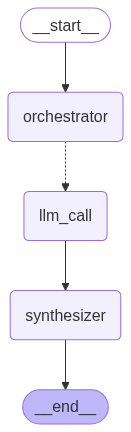

In [54]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [93]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
# Markdown(state["final_report"])

In [58]:
# for step in orchestrator_worker.stream({"topic": "Create a report on LLM scaling laws"}):
#     print(step)

### Evaluator-optimizer (Actor-Critic)

In [59]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/evaluator_optimizer.png', width=500)

- In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.
- When to use this workflow: This workflow is particularly effective when we have **clear evaluation criteria**, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

In [60]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

In [61]:
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [62]:
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


In [63]:
def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

In [64]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

In [65]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

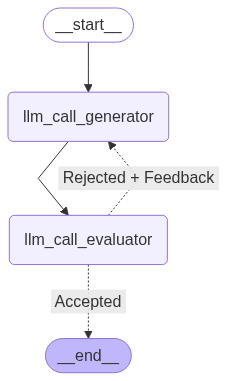

In [66]:
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [67]:
for step in optimizer_workflow.stream({"topic": "Cats"}):
    print(step)

{'llm_call_generator': {'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}}
{'llm_call_evaluator': {'funny_or_not': 'funny', 'feedback': ''}}


### Agent

- Environment 接受 Action 返回 feedback

In [69]:
Image(url='https://langchain-ai.github.io/langgraph/tutorials/workflows/img/agent.png', width=500)

In [75]:
Image(url='https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/8f/5e/reinforcement-learning-figure-1.png', width=500)

In [85]:
import numpy as np

In [90]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first float
        b: second float
    """
    return a * b


@tool
def add(a: float, b: float) -> float:
    """Adds a and b.

    Args:
        a: first float
        b: second float
    """
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """subtract a from b.

    Args:
        a: first float
        b: second float
    """
    return a - b

@tool
def divide(a: float, b: float) -> float:
    """Divide a and b.

    Args:
        a: first float
        b: second float
    """
    return a / b

@tool
def sigmoid(a: float) -> float:
    """sigmoid(a)
    Args: 
        a: first float
    """
    return 1./(1+np.exp(-a))


# Augment the LLM with tools
tools = [add, subtract, multiply, divide, sigmoid]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

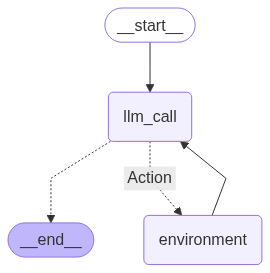

In [91]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [92]:

# Invoke
messages = [HumanMessage(content="calculate derivative of sigmoid(5)")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

calculate derivative of sigmoid(5)
================================== Ai Message ==================================
Tool Calls:
  sigmoid (call_yhe0L1h0iirYx86Oc4tGbHHm)
 Call ID: call_yhe0L1h0iirYx86Oc4tGbHHm
  Args:
    a: 5
================================= Tool Message =================================

0.9933071490757153
================================== Ai Message ==================================
Tool Calls:
  multiply (call_eepwJz1ggN5uMOU3hCNOir1V)
 Call ID: call_eepwJz1ggN5uMOU3hCNOir1V
  Args:
    a: 0.9933071490757153
    b: 0.006692850924284857
================================= Tool Message =================================

0.006648056670790157
================================== Ai Message ==================================

The derivative of the sigmoid function at \( \text{sigmoid}(5) \) is approximately \( 0.00665 \).
